In [0]:
%load_ext lab_black

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
from wordcloud import WordCloud

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy_syllables import SpacySyllables
from textstat import syllable_count

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16, 12]

import pyLDAvis.gensim_models
import plotly.express as px
from gensim.corpora.dictionary import Dictionary

pyLDAvis.enable_notebook()
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

import math
import swifter
from functools import reduce

import os

os.chdir("..")

ModuleNotFoundError: No module named 'spacytextblob'

# EDA

Autorzy: Dawid Płudowski, Antoni Zajko

In [ ]:
df = pd.read_pickle("resources/data/train_data.pkl")
df.head(5)

,doc_id,bow_dict,label
0,8018,"{'afternoon': 1, 'attached': 1, 'board': 1, 'b...",enron
1,126257,"{'accomplished': 1, 'account': 2, 'actor': 6, ...",nytimes
2,278701,"{'able': 1, 'ace': 1, 'advantage': 1, 'adverti...",nytimes
3,97518,"{'able': 1, 'abortion': 5, 'abundance': 1, 'ab...",nytimes
4,157394,"{'according': 1, 'actually': 1, 'address': 1, ...",nytimes


In [ ]:
X, y = df["bow_dict"], df["label"]

**TODO:**
* ~~Średnia długość tekstu(w tokenach) ze względu na label~~ - D
* ~~Barplot 20 najczęstszych słów dla każdego typu labelu~~ - D
* ~~histogram document frequency dla słów~~ - D
* ~~Histogram wystąpień słów - D~~
* ~~Histogram długości tokenów - D~~
* ~~Wordcloud dla kazdego labela i dla calego zbioru - D~~
* LDA - A
* scattertext - A
* ~~sentiment (polarity, subjectivity)~~
* analiza złożoności tekstu - D ~ *nie znalazłem biblioteki, która by to robiła na słownikach, a konwersja na tekst jest całkiem bolesna* 

In [ ]:
# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")
nlp.add_pipe("spacytextblob")
nlp.add_pipe("syllables", after="tagger")


class BowDicstWrapper:
    def __init__(self, bow_dicts, labels=None, init_dicts=True):
        self.bow_dicts = bow_dicts
        self.labels = labels

        self.labelwise_wordcount = None
        self.wordcount = None
        self.labelwise_word_frequency = None
        self.word_frequency = None
        self.vocab = None
        self.tokens = None

        if init_dicts:
            self.create_dicts()

    def create_dicts(self):
        if self.labels is not None:
            self._create_all_dicts()
        else:
            self._simple_dicts()

    def _create_vocab(self):
        self.vocab = [x for x in self.wordcount.keys() if type(x) is str]

    def _create_tokens(self):
        self.tokens = list(nlp.pipe(self.vocab))

    def _create_all_dicts(self):

        self.labelwise_wordcount = {
            "enron": {},
            "nytimes": {},
            "nips": {},
            "pubmed": {},
            "kos": {},
        }

        self.labelwise_word_frequency = {
            "enron": {},
            "nytimes": {},
            "nips": {},
            "pubmed": {},
            "kos": {},
        }

        self.wordcount = {}
        self.word_frequency = {}

        for words, label in zip(self.bow_dicts, self.labels):
            for word in words:
                if word in self.labelwise_word_frequency[label]:
                    self.labelwise_word_frequency[label][word] += 1
                    self.labelwise_wordcount[label][word] += words[word]
                else:
                    self.labelwise_word_frequency[label][word] = 1
                    self.labelwise_wordcount[label][word] = words[word]
                if word in self.word_frequency:
                    self.word_frequency[word] += 1
                    self.wordcount[word] += words[word]
                else:
                    self.word_frequency[word] = 1
                    self.wordcount[word] = words[word]

        self._create_vocab()
        self._create_tokens()

    def _simple_dicts(self):
        raise NotImplementedError("guess who didn't implement that method yet lol")

In [ ]:
# takes around 1 minute
bow_dicts = BowDicstWrapper(df["bow_dict"], labels=df["label"])

## Śednia długość tekstu 

In [ ]:
tmp_df = df.copy()
tmp_df["article_len"] = tmp_df.apply(lambda x: sum(x["bow_dict"].values()), axis=1)

mean_lens = tmp_df.groupby("label")["article_len"].agg("mean")

<AxesSubplot:xlabel='label'>

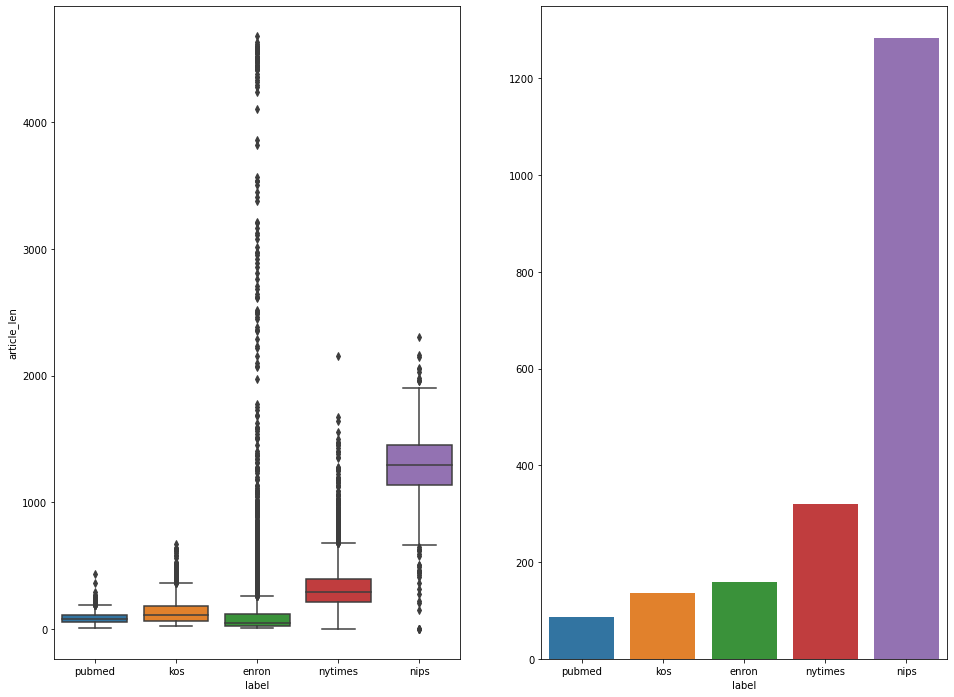

In [ ]:
order = ["pubmed", "kos", "enron", "nytimes", "nips"]

plt.subplot(1, 2, 1)
sns.boxplot(x="label", y="article_len", data=tmp_df, order=order)

plt.subplot(1, 2, 2)
sns.barplot(
    x=mean_lens.index,
    y=mean_lens.values,
    order=order,
)

## Barplot najczęstszych słów

[Text(0.5, 1.0, 'TOP 20 words for all articles')]

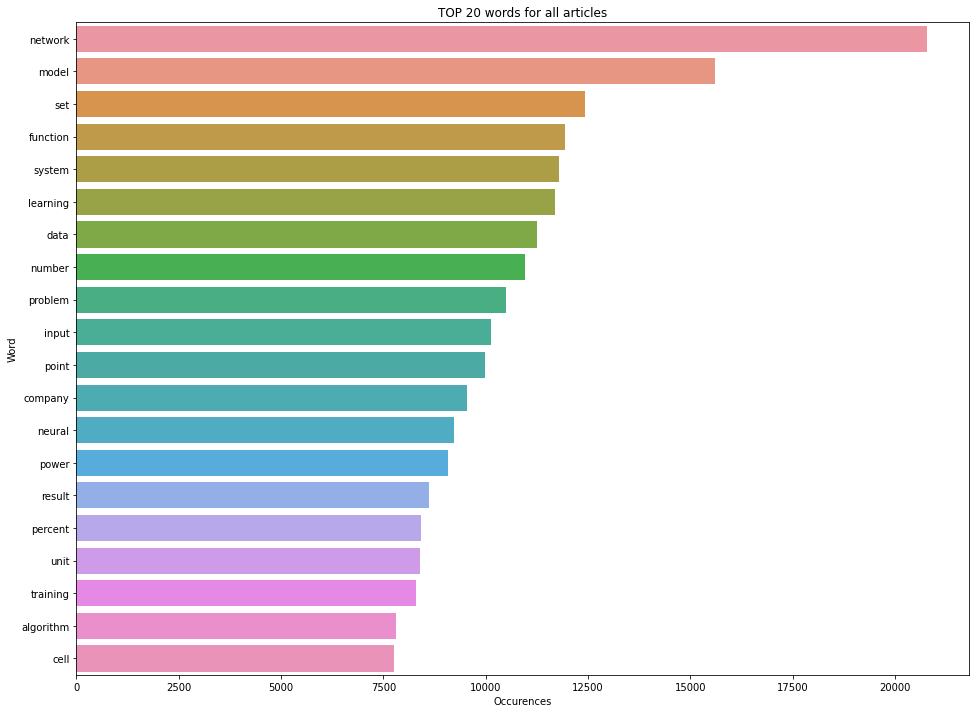

In [ ]:
wordcount_tuple = list(bow_dicts.wordcount.items())
wordcount_tuple.sort(key=lambda x: x[1], reverse=True)

tmp_df = pd.DataFrame(wordcount_tuple[:20], columns=["Word", "Occurences"])

sns.barplot(x="Occurences", y="Word", data=tmp_df).set(
    title="TOP 20 words for all articles"
)

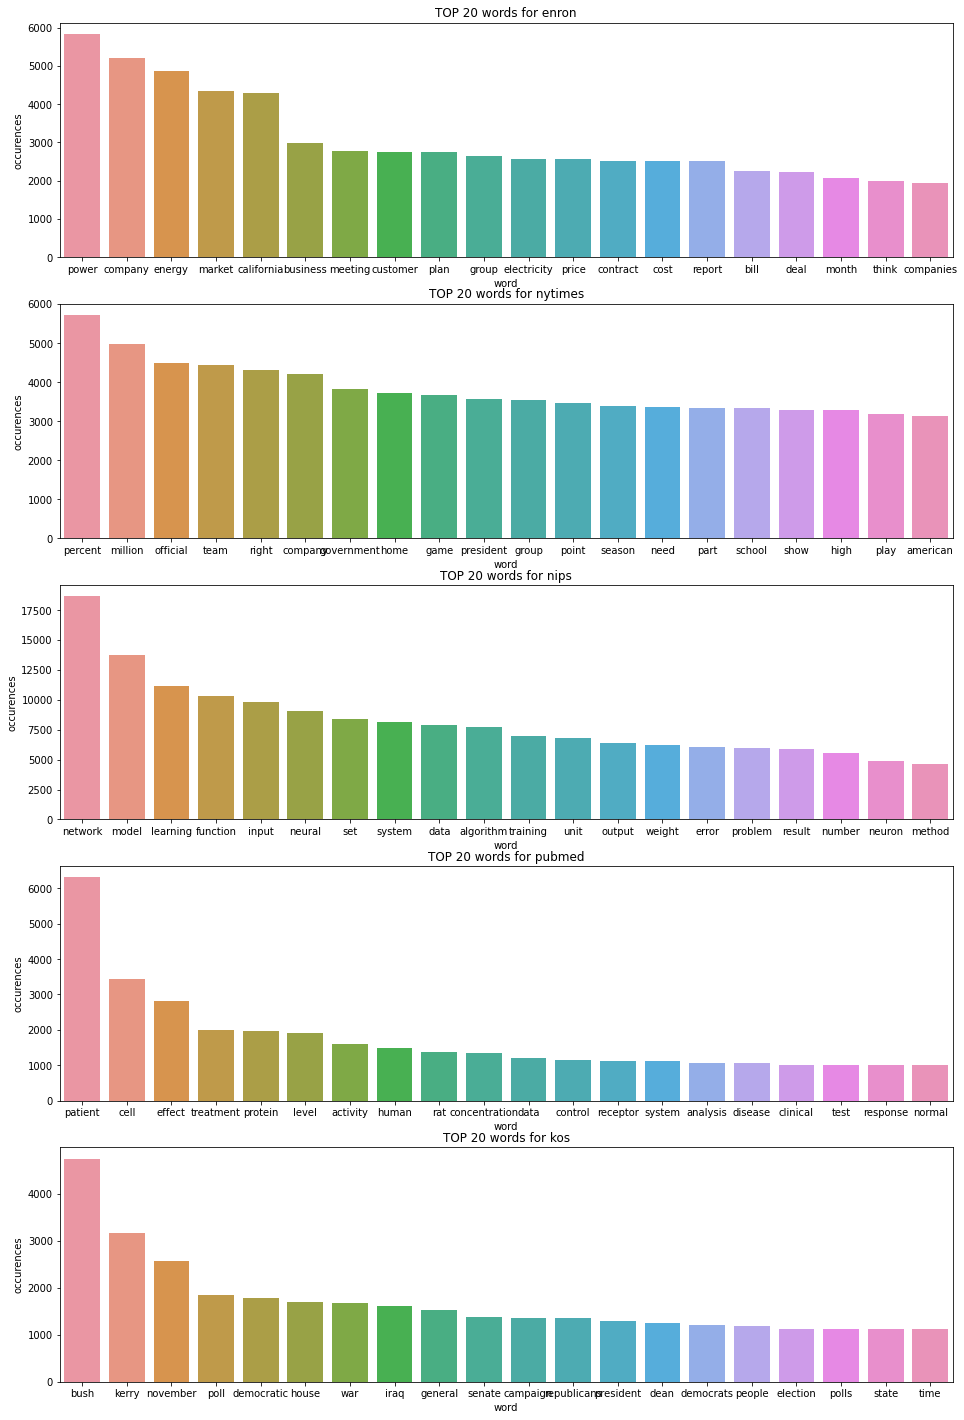

In [ ]:
tmp_df = pd.DataFrame(columns=["word", "occurences", "label"])
plt.figure(figsize=(16, 25))

for label in bow_dicts.labelwise_wordcount:
    new_df = pd.DataFrame(
        data=(bow_dicts.labelwise_wordcount[label].items()),
        columns=["word", "occurences"],
    )
    new_df["label"] = label
    tmp_df = pd.concat([tmp_df, new_df], axis=0)

for index, label in enumerate(bow_dicts.labelwise_wordcount):
    plt.subplot(5, 1, index + 1)
    ddf = (
        tmp_df.loc[tmp_df["label"] == label]
        .sort_values(by="occurences", ascending=False)
        .head(20)
    )
    sns.barplot(x="word", y="occurences", data=ddf).set(
        title=f"TOP 20 words for {label}"
    )

## Histogram wystąpień słów

<AxesSubplot:xlabel='Occurences', ylabel='Count'>

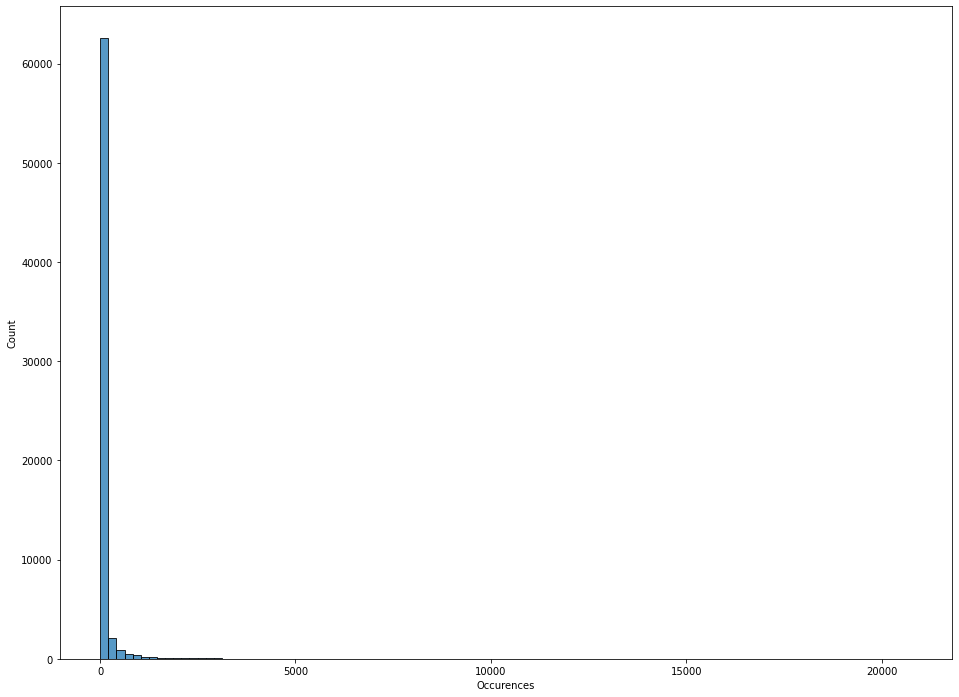

In [ ]:
df_words = pd.DataFrame(
    list(bow_dicts.wordcount.items()), columns=["Word", "Occurences"]
)

sns.histplot(x="Occurences", data=df_words, bins=100)

<AxesSubplot:xlabel='Occurences', ylabel='Count'>

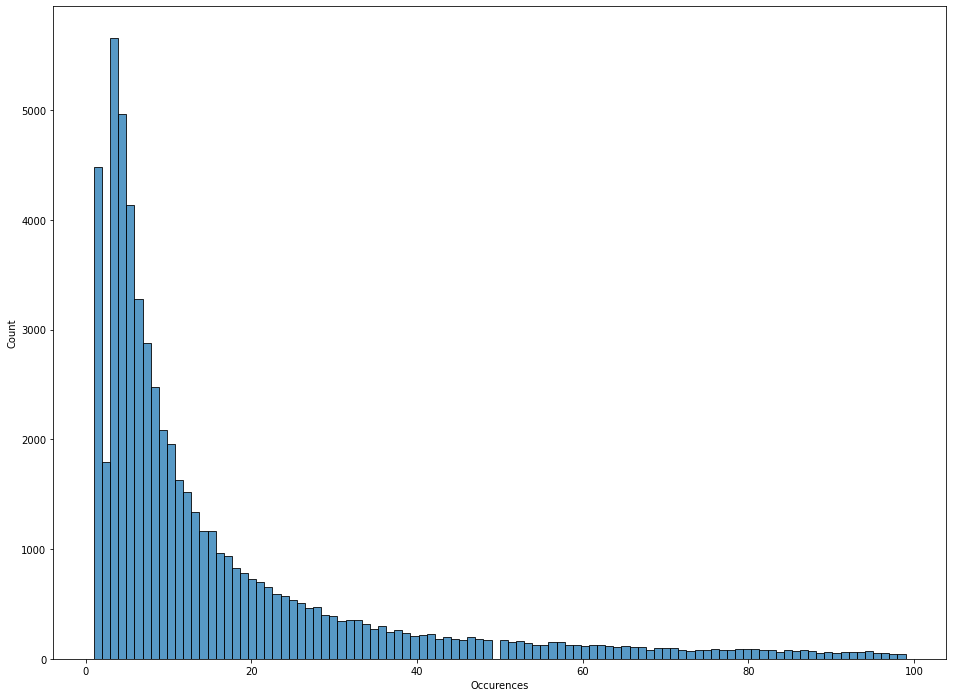

In [ ]:
# tylko dla małych liczności

sns.histplot(x="Occurences", data=df_words.loc[df_words["Occurences"] < 100], bins=100)

## Worldcloud bez podziału na labele 

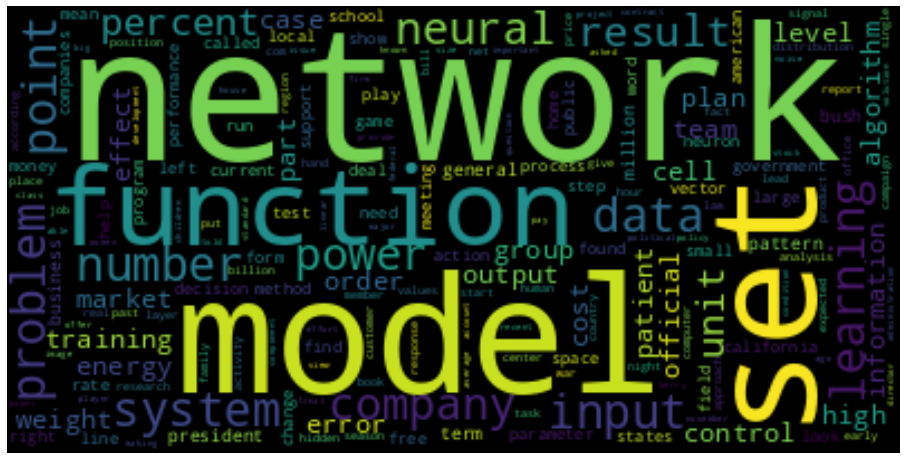

In [ ]:
wc = WordCloud()
wc.generate_from_frequencies(bow_dicts.wordcount)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

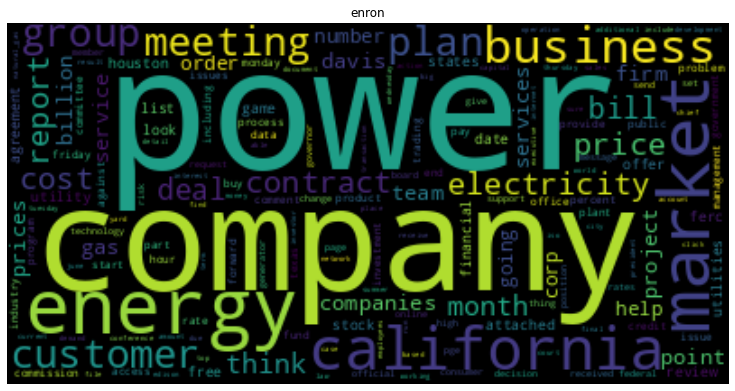

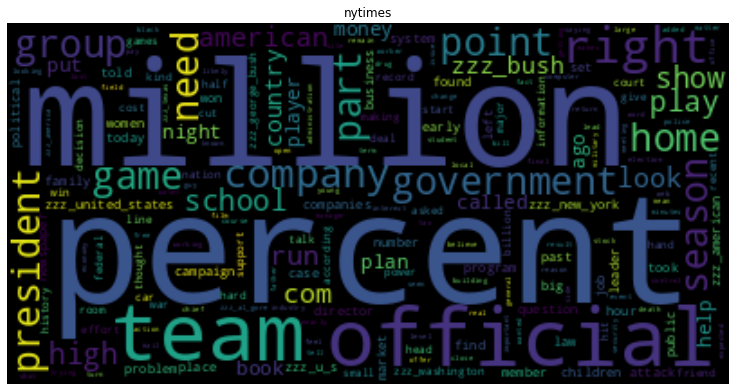

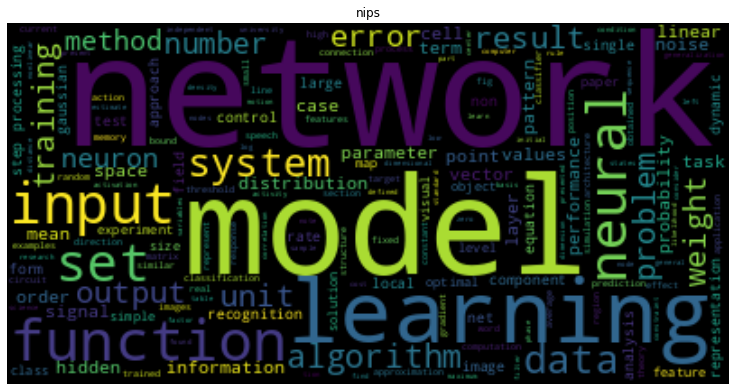

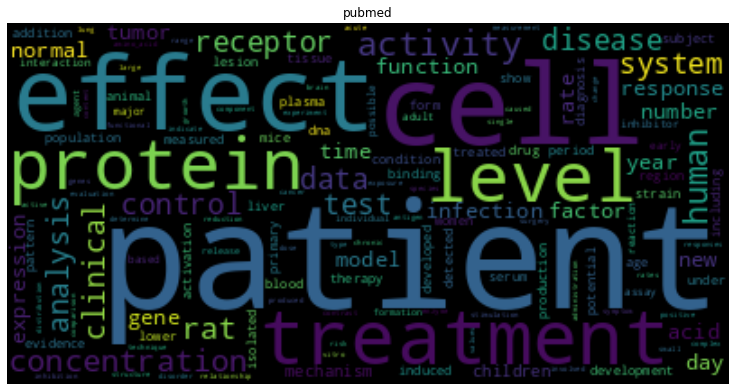

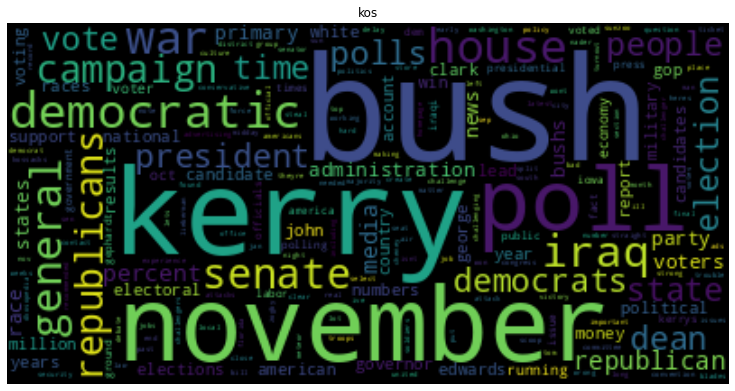

In [ ]:
for index, label in enumerate(bow_dicts.labelwise_wordcount):
    wc = WordCloud(width=400, height=200)
    wc.generate_from_frequencies(bow_dicts.labelwise_wordcount[label])
    plt.figure(figsize=(75, 10))
    plt.subplot(1, 5, index + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(label)
    plt.show()

## Histogram occurence frequency

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

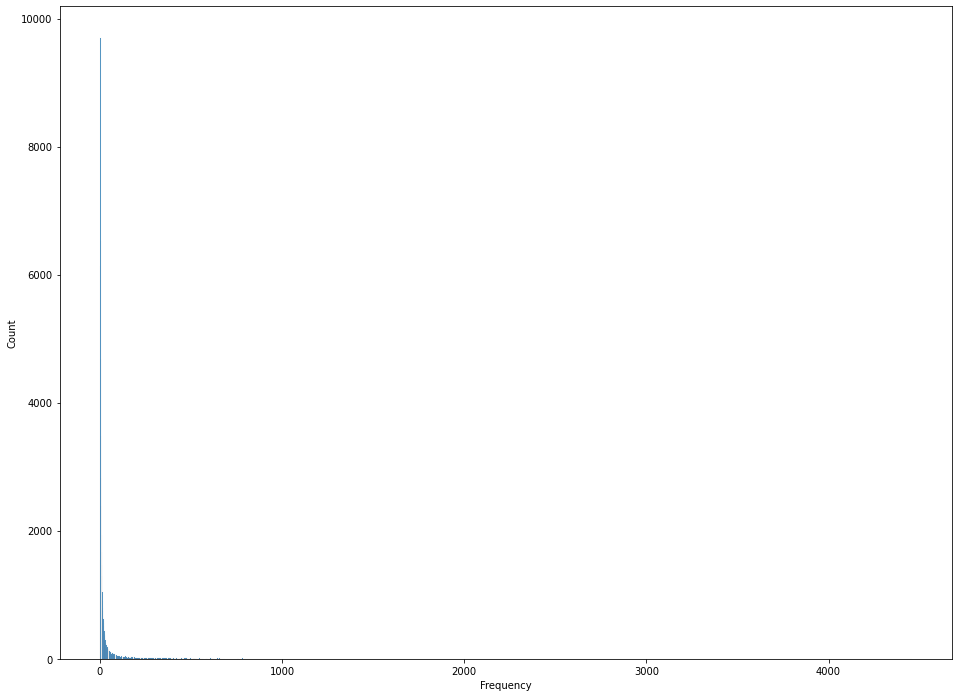

In [ ]:
df_words = pd.DataFrame(
    list(bow_dicts.word_frequency.items()), columns=["Word", "Frequency"]
)

sns.histplot(x="Frequency", data=df_words)

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

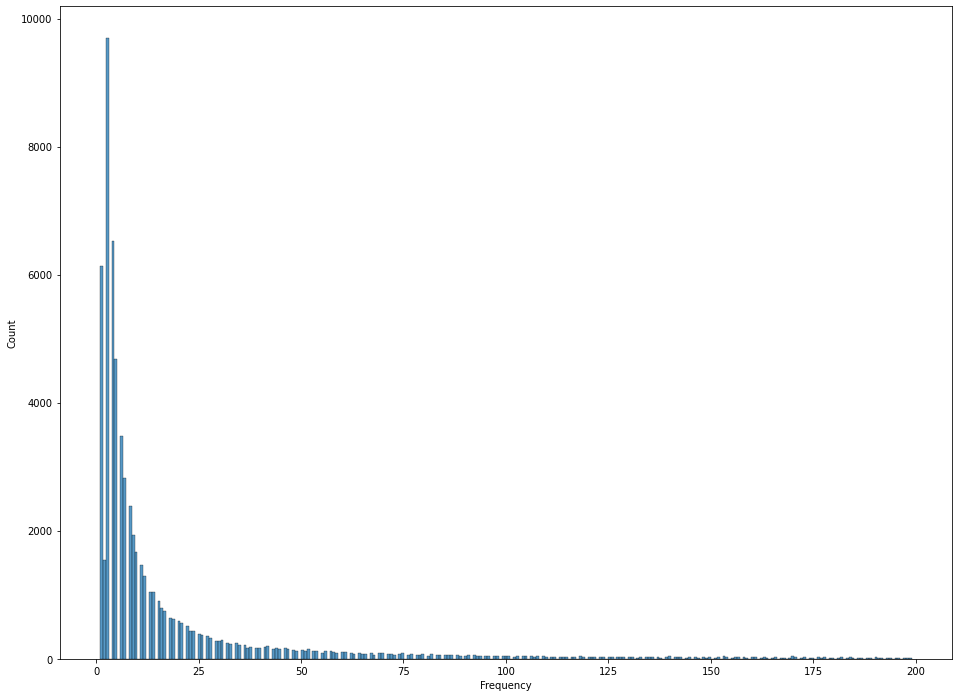

In [ ]:
sns.histplot(x="Frequency", data=df_words.loc[df_words["Frequency"] < 200])

## Histogram długości tokenów

In [ ]:
lens = list(map(lambda x: len(x), bow_dicts.vocab))

<AxesSubplot:ylabel='Frequency'>

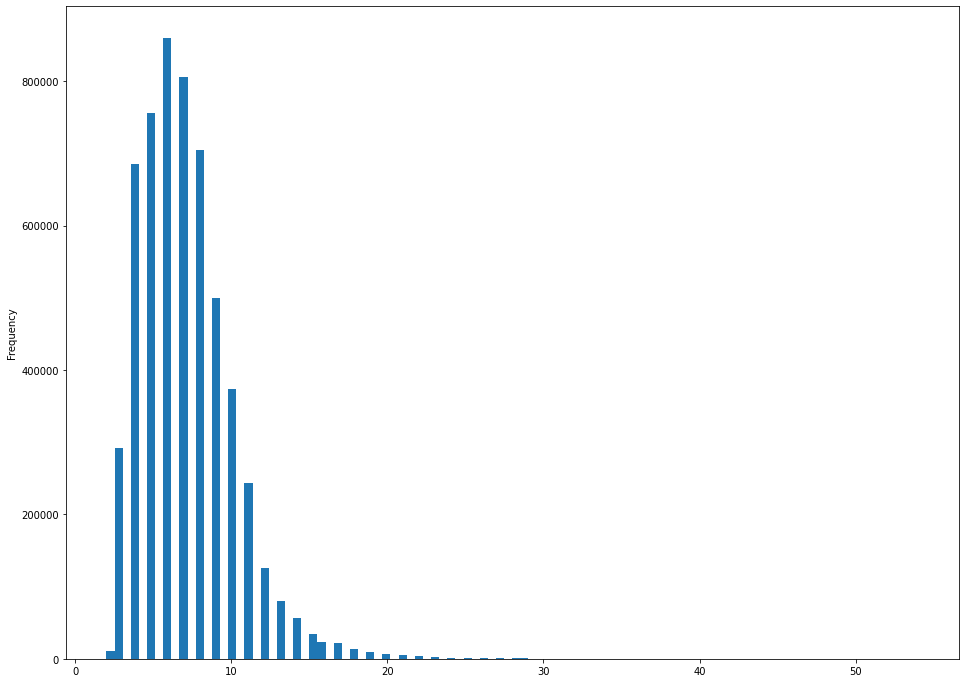

In [ ]:
df_words = pd.DataFrame(zip(lens, bow_dicts.vocab), columns=["word_length", "word"])

df_wordcount = pd.DataFrame(
    list(bow_dicts.wordcount.items()), columns=["word", "occurences"]
)

df_merged = df_words.merge(df_wordcount, on="word")
df_merged["sum_len"] = df_merged["word_length"] * df_merged["occurences"]

df_merged["word_length"].plot(kind="hist", weights=df_merged["occurences"], bins=100)

## Sentiment & objectivity 

In [ ]:
tmp_df = pd.DataFrame(bow_dicts.tokens)
tmp_df = tmp_df.rename(columns={0: "token"})
tmp_df = tmp_df[["token"]]
tmp_df["word"] = tmp_df["token"].apply(lambda x: x.text)
tmp_df["polarity"] = tmp_df["token"].apply(lambda x: x._.blob.polarity)
tmp_df["subjectivity"] = tmp_df["token"].apply(lambda x: x._.blob.subjectivity)

df_wordcount = pd.DataFrame(
    list(bow_dicts.wordcount.items()), columns=["word", "occurences"]
)

df_merged = tmp_df.merge(df_wordcount, on="word")

<AxesSubplot:ylabel='Frequency'>

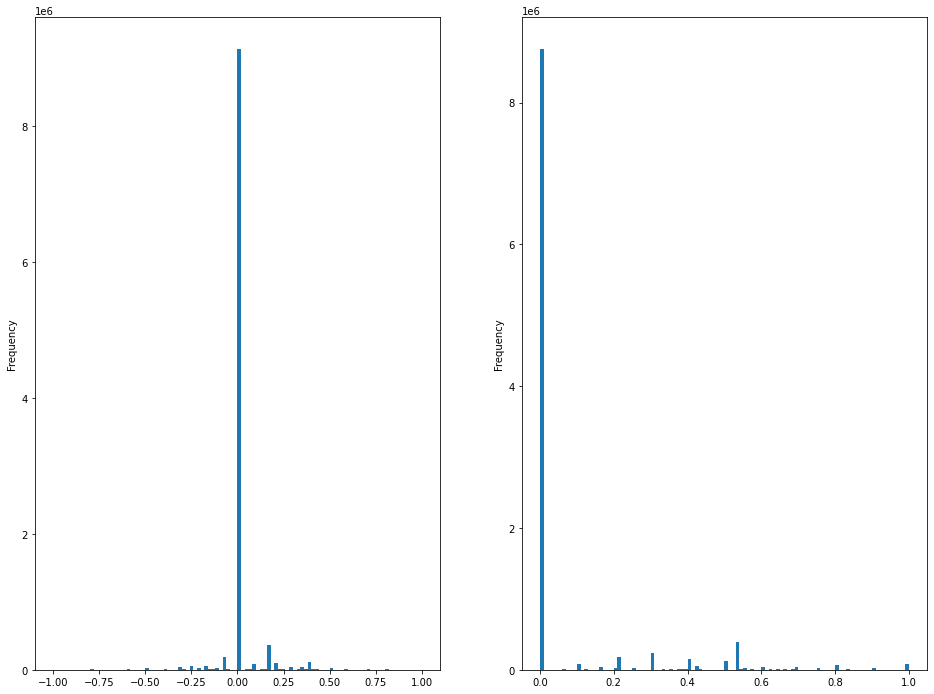

In [ ]:
plt.subplot(1, 2, 1)
df_merged["polarity"].plot(kind="hist", weights=df_merged["occurences"], bins=100)

plt.subplot(1, 2, 2)
df_merged["subjectivity"].plot(kind="hist", weights=df_merged["occurences"], bins=100)

<AxesSubplot:ylabel='Frequency'>

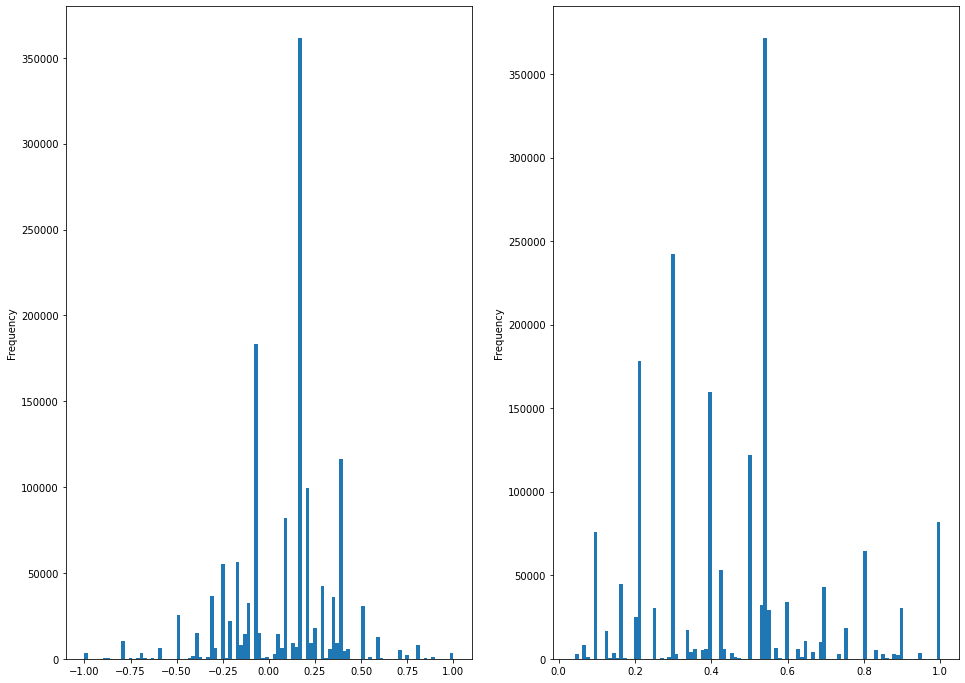

In [ ]:
# po usunięciu wartości neutralnych

plt.subplot(1, 2, 1)
df_merged["polarity"].loc[df_merged["polarity"] != 0].plot(
    kind="hist",
    weights=df_merged["occurences"].loc[df_merged["polarity"] != 0],
    bins=100,
)

plt.subplot(1, 2, 2)
df_merged["subjectivity"].loc[df_merged["subjectivity"] != 0].plot(
    kind="hist",
    weights=df_merged["occurences"].loc[df_merged["subjectivity"] != 0],
    bins=100,
)

## Text complexity

In terms of:

$$
score~~=~~\frac{polysyllabels}{N}
$$

where $N$ is total number of words

In [ ]:
tmp_df = df.copy()
tmp_df['len'] = tmp_df['bow_dict'].apply(lambda x: sum(x.values()))

In [ ]:
def count_pollysylables(old_dict):
    count = 0
    for key in old_dict.keys():
        if type(key) is str and syllable_count(key) > 2:
            count += old_dict[key]
    return count

In [ ]:
tmp_df['polysyllabels'] = tmp_df['bow_dict'].apply(count_pollysylables)
tmp_df['smog_frac'] = tmp_df['polysyllabels'] / tmp_df['len']

<AxesSubplot:xlabel='label', ylabel='smog_frac'>

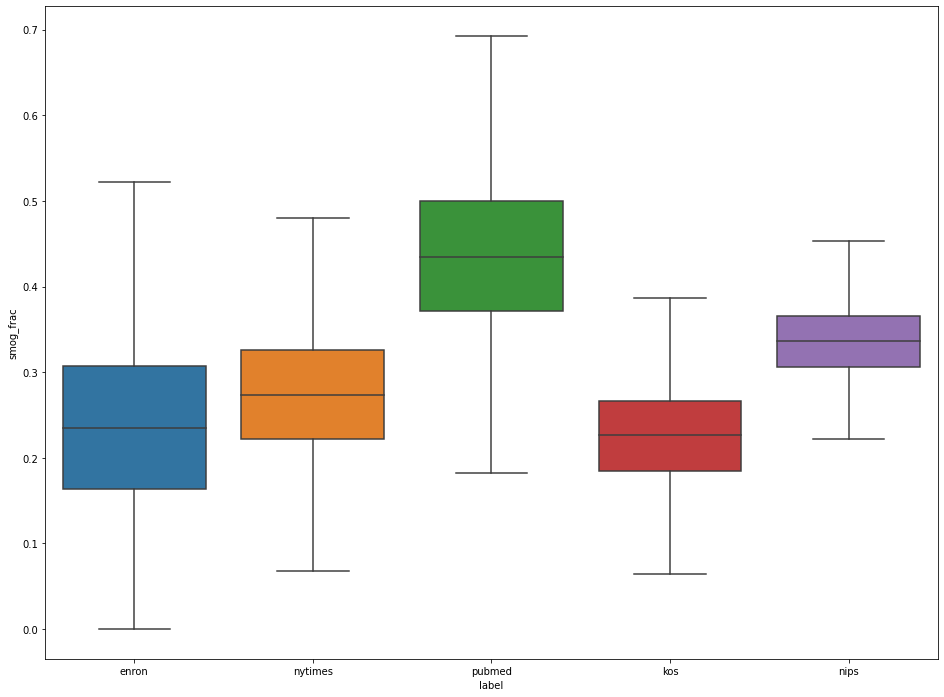

In [ ]:
sns.boxplot(y='smog_frac', x='label', data=tmp_df, showfliers=False)

## LDA

In [ ]:
def bow_to_list(bow):
    l = [[item[0]]*item[1] for item in bow.items()]
    l = [str(item) for sublist in l for item in sublist]
    return l

In [ ]:
token_lists = X.swifter.apply(bow_to_list)

dictionary = Dictionary(token_lists)
bows = token_lists.apply(dictionary.doc2bow)

lda = LdaMulticore(bows, num_topics=4)
vis = pyLDAvis.gensim_models.prepare(lda, bows, dictionary=dictionary)
vis

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pandas Apply:   0%|          | 0/24281 [00:00<?, ?it/s]

### Scattertext

In [ ]:
import scattertext as st

token_lists = X.swifter.apply(bow_to_list)
artificial_texts = X.swifter.apply(lambda l: ' '.join([str(el) for el in l]))

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.028979  0.003426       1        1  33.154988
3     -0.023390 -0.003694       2        1  29.492165
2      0.003259 -0.015143       3        1  22.133507
0     -0.008848  0.015411       4        1  15.219341, topic_info=          Term          Freq         Total Category  logprob  loglift
2589     model  13912.000000  13912.000000  Default  30.0000  30.0000
203    network  19674.000000  19674.000000  Default  29.0000  29.0000
1550     input   8848.000000   8848.000000  Default  28.0000  28.0000
1547  function  10901.000000  10901.000000  Default  27.0000  27.0000
1428  learning  10991.000000  10991.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1166      case   1115.526710   6159.126463   Topic4  -6.6648   0.1740
1618    energy   1154.463929   6879.276991   Topic4  -6.6305   0.0977
4085      unit   1161.789287   8070.234767   Topic4  -6.6242  -0.0556
370       high   1071.149326   6201.224999   Topic4  -6.7054   0.1266
700      power   1080.327286   9047.778936   Topic4  -6.6969  -0.2427

[423 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
34251      3  0.943791              123i-imp
71093      1  0.925628                 86rb+
2553       1  0.175703              activity
2553       2  0.500247              activity
2553       3  0.227510              activity
...      ...       ...                   ...
40904      4  0.024711           zzz_veteran
1153       1  0.939381  zzz_vinny_testaverde
1153       2  0.025050  zzz_vinny_testaverde
1153       3  0.012525  zzz_vinny_testaverde
1153       4  0.025050  zzz_vinny_testaverde

[1105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [ ]:
categories = np.unique(df['label'])

In [ ]:
# df['text'] = artificial_texts
# df = df.assign(
#     parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences)
# )
# df.to_pickle("notebooks/resources/df_with_parsed.pkl")
df = pd.read_pickle("notebooks/resources/df_with_parsed.pkl")

print("Create corpus")
corpus = st.CorpusFromParsedDocuments(
    df, category_col='label', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

for category in categories:
    print(f"Create html for {category}")
    html = st.produce_scattertext_explorer(
        corpus,
        category=category, 
        minimum_term_frequency=10, 
        pmi_threshold_coefficient=0,
        width_in_pixels=1000, 
        transform=st.Scalers.dense_rank
    )
    open(f'notebooks/resources/scatter_{category}.html', 'w').write(html)

#### enron
![](resources/scatter_enron.png)

#### kos
![](resources/scatter_kos.png)

#### nips
![](resources/scatter_nips.png)

#### nytimes
![](resources/scatter_nytimes.png)

#### pubmed
![](resources/scatter_pubmed.png)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2806cd9-5cf3-4675-a7be-a9a90ed3a708' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>